In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func,distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table   # Reflect Database into ORM class
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
pd.DataFrame(columns)


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


In [11]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
# Query measurement and station and save the query into results_m
results_m = session.query(Measurement.id, Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs).all()

In [14]:
# Load the results into a pandas dataframe. 
measurement_df = pd.DataFrame(results_m, columns=['id', 'station', 'date','prcp','tobs'])
measurement_df.set_index('id', inplace=True, )
measurement_df.head(10)

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,NaN,73.0
6,USC00519397,2010-01-07,0.06,70.0
7,USC00519397,2010-01-08,0.00,64.0
8,USC00519397,2010-01-09,0.00,68.0
9,USC00519397,2010-01-10,0.00,73.0


# Exploratory Climate Analysis

In [15]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data



# Total dates
session.query(func.count(Measurement.date)).all()
# Earliest and Latest Date
earliest_date=session.query(Measurement.date).order_by(Measurement.date).first()
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest date of the database {earliest_date}")
print(f"Latest date of the database {latest_date}")
print(type(earliest_date))
from datetime import date
from dateutil.relativedelta import relativedelta
twelve_months = str(dt.date(2017, 8, 23) - relativedelta(months=+12))
print(type(twelve_months))
print(f"The last 12 months to plot the data will query until this date {twelve_months}")

#SELECT COUNT (*) FROM Measurement WHERE date >= query date AND date < = latest_date

twelve_months_query =session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= twelve_months).\
                                            order_by(Measurement.date.asc()).group_by(Measurement.date).all()

twelve_months_query

# Load the results into a pandas dataframe. Set the index to the `id`
df = pd.DataFrame(twelve_months_query, columns=['date','prcp'])
#df.set_index('id', inplace=True, )
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.strftime('%m').astype(str)
df['year'] = df['date'].dt.year.astype(str)

df1=df.groupby(['date']).sum().reset_index()

df1=df1[df1!=0].dropna()
df1

Earliest date of the database ('2010-01-01',)
Latest date of the database ('2017-08-23',)
<class 'sqlalchemy.util._collections.result'>
<class 'str'>
The last 12 months to plot the data will query until this date 2016-08-23


,date,prcp
1,2016-08-24,0.08
2,2016-08-25,0.08
5,2016-08-28,0.01
8,2016-08-31,0.13
12,2016-09-04,0.03
...,...,...
333,2017-07-22,0.03
335,2017-07-24,0.05
343,2017-08-01,0.02
346,2017-08-04,0.02


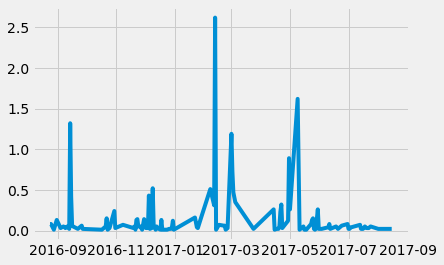

In [71]:
plt.plot(df1['date'],df1['prcp'],label="precipitation")


In [100]:
df2 = df.groupby(['month','year'])['prcp'].sum().reset_index()
#df2=df2.sort_values(['year','month'],ascending=True,inplace=True)
df2['month-year']= df2['month']+"-"+df2['year']
df2=df2.sort_values(['month-year'],ascending=True)
df2

,month,year,prcp,month-year
0,01,2017,0.41,01-2017
1,02,2017,3.68,02-2017
2,03,2017,2.76,03-2017
3,04,2017,1.95,04-2017
4,05,2017,2.65,05-2017
5,06,2017,0.37,06-2017
6,07,2017,0.42,07-2017
7,08,2016,0.30,08-2016
8,08,2017,0.06,08-2017
9,09,2016,2.13,09-2016


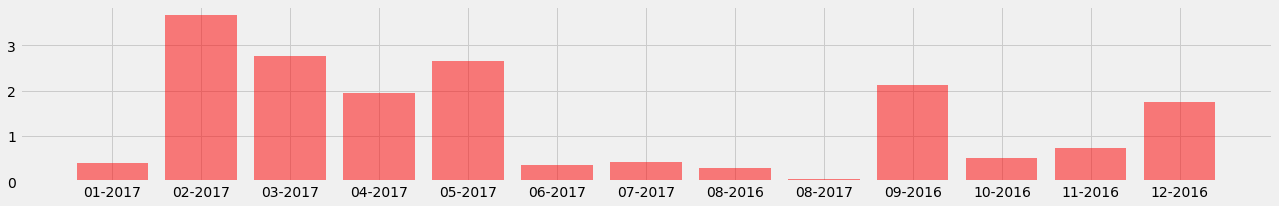

In [91]:
plt.figure(figsize=(20,3))
y_axis = df2['prcp']
x_axis = np.arange(len(y_axis))
plt.bar(x_axis,y_axis,color='r', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations,df2['month-year'])
plt.show()


In [101]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [102]:
# Create our session (link) from Python to the DB
session = Session(engine)

results_s = session.query(Station.id, Station.station, Station.name,Station.latitude,Station.longitude,Station.elevation).all()

# Load the results into a pandas dataframe. 
station_df = pd.DataFrame(results_s, columns=['id','station', 'name','latitude','longitude','elevation'])
station_df.set_index('id', inplace=True, )
station_df.head(10)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
pd.DataFrame(columns)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [103]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
r1=session.query(Measurement.station,func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
r1

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [104]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
rmin=session.query(Measurement.station,func.min(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(rmin)

rmax=session.query(Measurement.station,func.max(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(rmax)

ravg=session.query(Measurement.station,func.avg(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(ravg)

('USC00519281', 54.0)
('USC00519281', 85.0)
('USC00519281', 71.66378066378067)


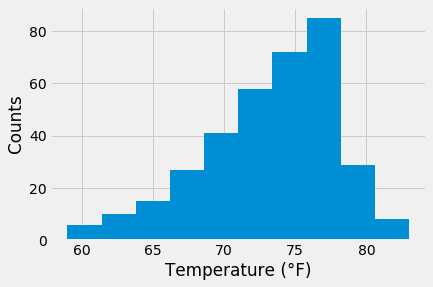

In [107]:
# Choose the station with the highest number of temperature observations.

r50=session.query(Measurement.id,Measurement.date,Measurement.tobs).\
filter(Measurement.station =='USC00519281').\
filter(Measurement.date > twelve_months).\
                      order_by(Measurement.date.asc()).group_by(Measurement.date).all()

# Load the results into a pandas dataframe. Set the index to the `id`
df = pd.DataFrame(r50, columns=['id','date','tobs'])
df.set_index('id', inplace=True, )
df

temperatures=df['tobs']
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(temperatures)
plt.xlabel('Temperature (°F)')
plt.ylabel('Counts')
plt.show()

## Bonus Challenge Assignment

In [112]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

#query_date = dt.date(2011, 4, 8)


print(f"Select a initial date between {earliest_date} and {latest_date}")
fecha_inicial = input("fecha inicial")
fecha_final =input("fecha final")
print(calc_temps(fecha_inicial,fecha_final))

[(62.0, 69.57142857142857, 74.0)]
Select a initial date between ('2010-01-01',) and ('2017-08-23',)
fecha inicial2016-11-21
fecha final2017-11-21
[(58.0, 73.78253012048192, 87.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f"Select a initial date between {earliest_date} and {latest_date}")
fecha_inicial = input("fecha inicial del viaje")
numero_dias_viaje =input("numero de dias")
fecha_final =fecha_inicial + numero_dias_viaje
print(calc_temps(fecha_inicial,fecha_final))

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Design a query to calculate the PTP for stock `IBM` after May, 2011
import datetime as dt
import numpy as np

date = dt.datetime(2011, 5, 31)

results = session.query(Dow.high_price - Dow.low_price).\
    filter(Dow.date > date).filter(Dow.stock == 'IBM').all()
    
ptps = list(np.ravel(results))

# List Comprehension Solution
#ptps = [result[0] for result in results]

ptps

# Load the query into a dataframe, set the index to the date, and plot the ptps
import numpy as np

fig, ax = plt.subplots()

x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('IBM PTPs')
fig.tight_layout()
plt.show()



In [ ]:
JOIN
same_sporder = session.query(EA, NA).filter(EA.sporder == NA.sporder).limit(10).all()


for record in same_sporder:
    (ea, na) = record
    #print("EA",ea.sporder)
    #print("NA", na.sporder)
    print("EA",ea.id, ea.sporder, "NA", na.id, na.sporder)
    
# Return all animals from EA and NA belonging to the same sporder.
# This JOINs the data in the two tables together into a single dataset (here in the form of a tuple).
# Note: We are going to limit the results to 10 for printing
sel = [EA.family, EA.genus, EA.species, NA.family, NA.genus, NA.species]
same_sporder = session.query(*sel).filter(EA.sporder == NA.sporder).limit(10).all()

for record in same_sporder:
    (ea_fam, ea_gen, ea_spec, na_fam, na_gen, na_spec) = record
    print(
        f"The European animal '{ea_fam} {ea_gen} {ea_spec}'"
        f"belongs to the same sporder as the North American animal '{na_fam} {na_gen} {na_spec}'.")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date




In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
